# Online Learning Project
## [Paper] "A Tutorial on Conformal Prediction" by Glenn Shafer and Vladimir Vovk

In this paper, the authors present a novel method for evualuating the **accuracy** of a model's predictions and establishing **confidence regions** that are valid both in the offline and **online** cases. This is done by introducing a **non-conformity measure** and computing a conformity score for every possible output using **previous data** (previously observed outcomes).

In this notebook we will implement the conformal prediction algorithm for both **classification** and **regression**.

#### Some imports and global variables :

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [67]:
from sys import maxsize

import pandas as pd
from scipy import stats
from sklearn.datasets import load_iris

import seaborn as sns

import multiset as ms

sns.set_style("whitegrid")
sns.set_context("talk")

### Multisets

We will be using Python's `multiset` module in order to manipulate sets where repetition is allowed and where order doesn't matter.

**Example :**

In [41]:
s = ms.Multiset([1,3,4,4,3,5,6])

print(f'A random multiset :\n{s}')
print()

print(f'The same multiset with an instances of 3 removed :\n{s.difference([3])}')

A random multiset :
{1, 3, 3, 4, 4, 5, 6}

The same multiset with an instances of 3 removed :
{1, 3, 4, 4, 5, 6}


# Exchangeability Model

The only hypothesis we need to use conformal prediction is that the samples of the training data are exchangeable. In the particular case were the samples are assumed to be i.i.d, this is obviously verified.

## Conformal Algorithm using old predictions alone

Let's generate random normal values :

In [90]:
def estimate_confidence_interval(Z, epsilon):
    quantile = stats.norm.ppf(q=1-epsilon/2)
    
    Z_mean = Z.cumsum()/(1 + np.arange(len(Z)))

    S = (Z - Z_mean)**2
    Z_std = S.cumsum()/(np.arange(-1, len(S)-1))
    Z_std[:2] = np.nan
    Z_std = np.sqrt(Z_std)

    lim_sup = Z_mean + quantile * Z_std
    lim_inf = Z_mean - quantile * Z_std
    return lim_inf, lim_sup

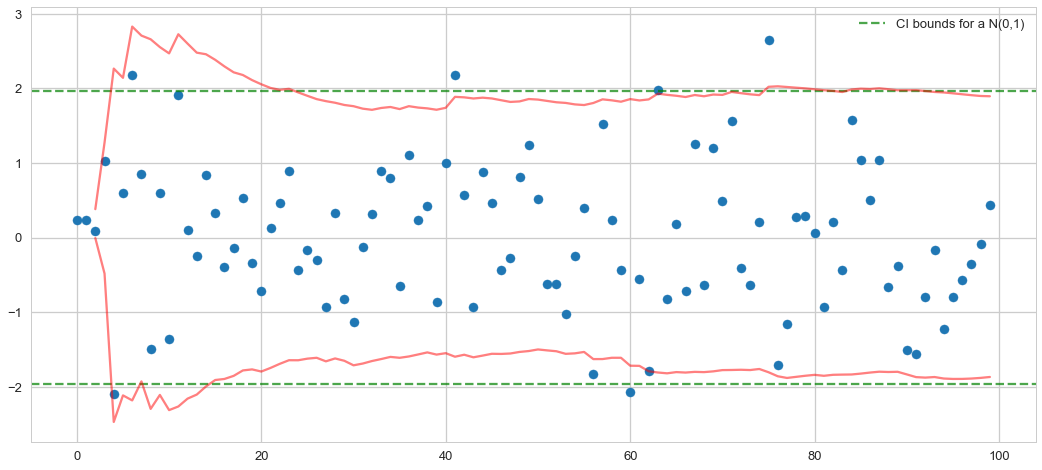

In [99]:
n = 100
epsilon = 0.05
q = stats.norm.ppf(q=1-epsilon/2)

Z = np.random.normal(size=n)
lim_inf, lim_sup = estimate_confidence_interval(Z, epsilon)

plt.figure(figsize=(18, 8))
plt.scatter(range(len(Z)), Z)
plt.axhline(y=q, color='green', linestyle='--', alpha=0.7, label="CI bounds for a N(0,1)")
plt.axhline(y=-q, color='green', linestyle='--', alpha=0.7)
plt.plot(lim_sup, color="red", alpha=0.5)
plt.plot(lim_inf, color="red", alpha=0.5)
plt.legend()
plt.show()

In [100]:
empirical_error = sum((Z > lim_sup) | (Z < lim_inf))/len(Z)
print(f'Empirical error for epsilon={epsilon} : {empirical_error}')

Empirical error for epsilon=0.05 : 0.05


To get nonconformal confidence regions, we need to define a nonconformity measure. A simple way to do that when predicting continuous values is to compute the absolute deviation from a good estimator that uses the previous data. In this case, the estimator will be the average of all previous values + the new value.

In [101]:
def nonconformity_measure(previous_values, new_value):
    estimation = np.sum(previous_values) + new_value
    estimation /= (len(previous_values) + 1.)
    
    return np.abs(estimation - new_value)

Let's plot the nonconformity measure :

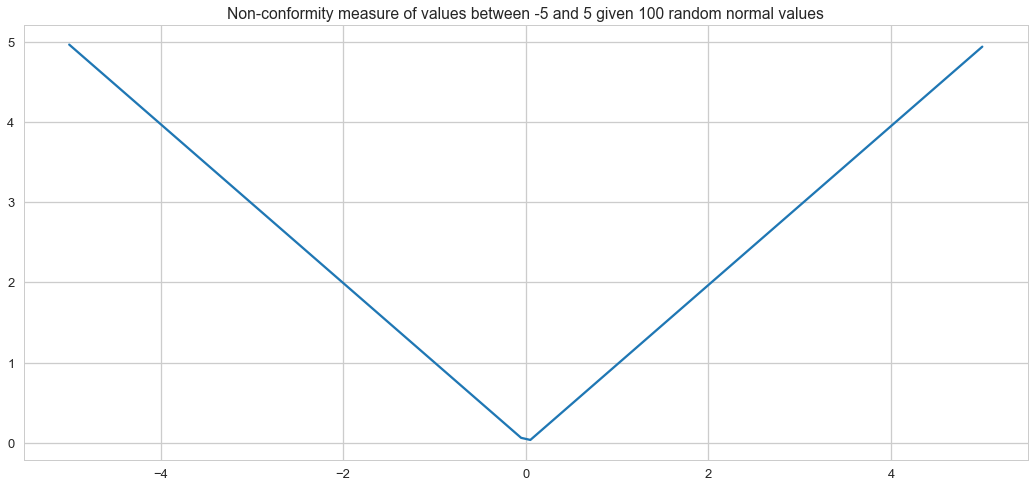

In [102]:
space = np.linspace(-5, 5, 100)
scores = [nonconformity_measure(Z, x) for x in space]

plt.figure(figsize=(18, 8))
plt.title(f"Non-conformity measure of values between -5 and 5 given {n} random normal values")
plt.plot(space, scores)
plt.show()

The non conformity measure is minimum in the most probable value : 0

In [103]:
def conformal_algorithm_from_old_examples(non_conformity_measure, previous_examples, new_example, epsilon=0.05):
    n = len(previous_examples) + 1
    examples = list(previous_examples) + [new_example]

    alphas = []
    for i in range(n):
        alphas.append(non_conformity_measure(examples[:i] + examples[i+1:], examples[i]))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p > epsilon, p

In [104]:
probabilities = [conformal_algorithm_from_old_examples(nonconformity_measure, Z, x, epsilon=0.05)[1] for x in space]

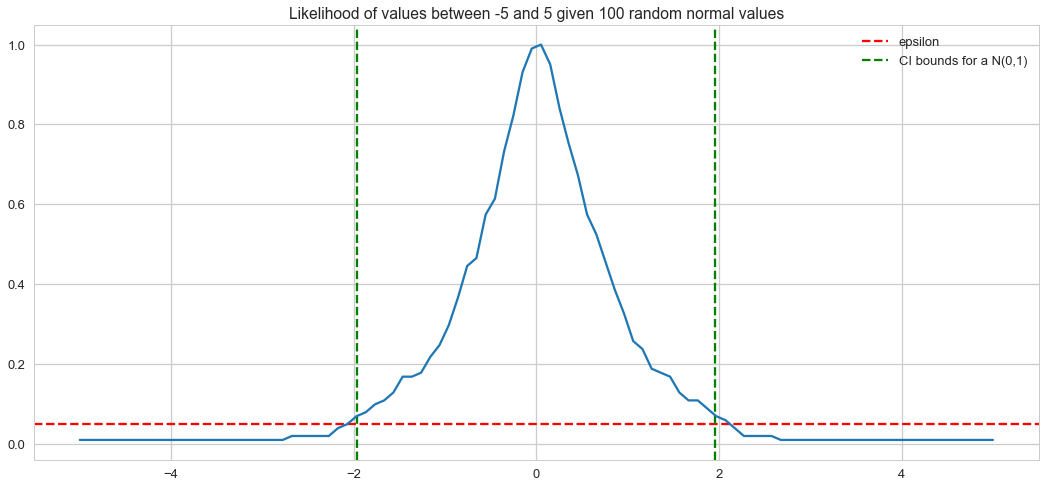

In [106]:
plt.figure(figsize=(18, 8))
plt.title(f"Likelihood of values between -5 and 5 given {n} random normal values")
plt.axhline(y=epsilon, color='r', linestyle='--', label="epsilon")
plt.axvline(x=stats.norm.ppf(q=1-epsilon/2), color='green', linestyle='--', label="CI bounds for a N(0,1)")
plt.axvline(x=-stats.norm.ppf(q=1-epsilon/2), color='green', linestyle='--')
plt.plot(space, probabilities)
plt.legend()
plt.show()

We can see that in this simple example, the confidence region that results from the conformal algorithm is slightly larger than the real confidence region for an N(0,1). Which means that the error is < epsilon.

### J'ai pas touché a tes trucs, j'ai repris un peu plus haut pour des random normal 

We first define the non-conformity measure associated with fisher problem.

In [52]:
def non_conformity_fisher(bag, example):
    n = len(bag)
    z_bar_bag = np.mean(bag)
    print(z_bar_bag*n)
    return(abs(((n*z_bar_bag+example)/(n+1))-example))

Then we can define the algorithm as stated in the paper :

In [38]:
def conformal_algorithm_from_old_examples(non_conformity_measure,previous_examples_list, example, error=.05):
    n = len(previous_examples_list)+1
    examples_list = previous_examples_list+[example]
    alpha = np.zeros(n)
    for i in range(n):
        bag = ms.Multiset(examples_list).difference([examples_list[i]])
        alpha[i] = non_conformity_measure(bag, examples_list[i])
    p_z = sum(alpha > alpha[n-1])/n
    return p_z >= error
        

Predicting for a number of reasonable values for z:

In [40]:
[conformal_algorithm_from_old_examples(non_conformity_fisher, list_fisher, i) for i in range(30)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False]

# 1.2 Conformal Algorithm using new object

Let's implement the nonconformity measure for nearest neighbours, as in the paper if the denominator is 0 and the numerator is not then the result should be infinity (or in this case the maximum integer computable) and if they are both equal to zero then we return 0.

In [127]:
def non_conformity_nn(bag, example, label):
    distance_to_z_nn_in_bag_same_label = min([abs(x-example) for (x,y) in bag if y == label])
    distance_to_z_nn_in_bag_diff_label = min([abs(x-example) for (x,y) in bag if y != label])
    if (distance_to_z_nn_in_bag_diff_label == 0)&(distance_to_z_nn_in_bag_same_label == 0):
        return 0. 
    if (distance_to_z_nn_in_bag_diff_label == 0):
        return maxsize-1
    return distance_to_z_nn_in_bag_same_label/distance_to_z_nn_in_bag_diff_label

Implementing the supervised version of the conformal algorithm.

In [183]:
def conformal_algorithm_using_new_object(non_conformity_measure,previous_examples_list, example, label, error=.05):
    n = len(previous_examples_list)+1
    examples_list = previous_examples_list+[(example, label)]
    alpha = np.zeros(n)
    for i in range(n):
        bag = ms.Multiset(examples_list).difference([examples_list[i]])
        alpha[i] = non_conformity_measure(bag, examples_list[i][0], examples_list[i][1])
    p_y = sum(alpha > alpha[n-1])/n
    return {"test_result":p_y >= error,
            "alpha":alpha,
            "1-p_y":1-p_y
           }

Loading Iris Dataset

In [207]:
X = pd.DataFrame(load_iris()["data"], columns=load_iris()["feature_names"])
y = pd.DataFrame(load_iris()["target"], columns=["species"])
X = X[y.species.isin([0,1])]
y = y[y.species.isin([0,1])]

df = pd.concat([X,y],axis=1).sample(n=25, random_state=320)

list_obs = [(example, label) for [example, label] in df[["sepal length (cm)", "species"]].values]

We plot the Iris dataset with respect to sepal length

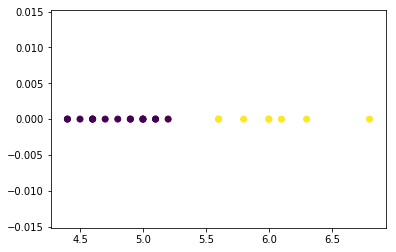

In [208]:
plt.scatter(df["sepal length (cm)"], np.zeros(25),c=df.species)

Conformal predictions for y = 0 and y = 1:

In [209]:
conformal_algorithm_using_new_object(non_conformity_nn, list_obs[:-1], list_obs[-1][0], 0.)

{'1-p_y': 0.84,
 'alpha': array([1.81818182e-01, 3.12500000e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.42857143e-01, 9.22337204e+18, 1.11111111e-01,
        0.00000000e+00, 9.22337204e+18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.50000000e-01]),
 'test_result': True}

In [210]:
conformal_algorithm_using_new_object(non_conformity_nn, list_obs[:-1], list_obs[-1][0], 1.)

{'1-p_y': 0.92,
 'alpha': array([1.81818182e-01, 3.12500000e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 9.22337204e+18, 1.11111111e-01,
        0.00000000e+00, 9.22337204e+18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.00000000e+00]),
 'test_result': True}

Comparing with ground truth :

In [190]:
list_obs[-1]

(4.8, 0.0)

- $\Gamma^{0,92}=\{0\}$ With confidence 92% we predict that $y_25=0$ like in the paper.
- $\Gamma^{0,95}=\{0,1\}$ No information when the confidence is too high like in the paper.
- $\Gamma^{0,33}=\emptyset$ False prediction exactly like in the paper.